In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import defaultdict
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from bgspy.theory import bgs_segment, bgs_rec
from bgspy.utils import signif

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [13]:
def group_means(d):
    d_ave = d.groupby(['key']).mean().reset_index()
    d_var = d.groupby(['key'])['y'].var().reset_index()
    d_var = d_var.rename(columns={'y': 'y_var'})
    d_grp = pd.concat((d_ave, d_var), axis=1).reset_index()
    return d_grp.sort_values(['sh'])

def subsample_reps(d, n, replace=False):
    return d.groupby(['key']).sample(n=n, replace=replace)

def load_validation(file):
    vda = np.load(file)
    vd = pd.DataFrame(vda['X'], columns=vda['features'])
    vdy = pd.DataFrame(vda['y'], columns=vda['targets'])
    vd['y'] = vdy['Bhat']
    vd['key'] = vda['keys']
    vd['theory'] = bgs_segment(vd['mu'], vd['sh'], vd['L'], vd['rbp'], vd['rf'])
    return vd

## Validation

In [15]:
vd = load_validation('../data/slim_sims/validate/validate.npz')

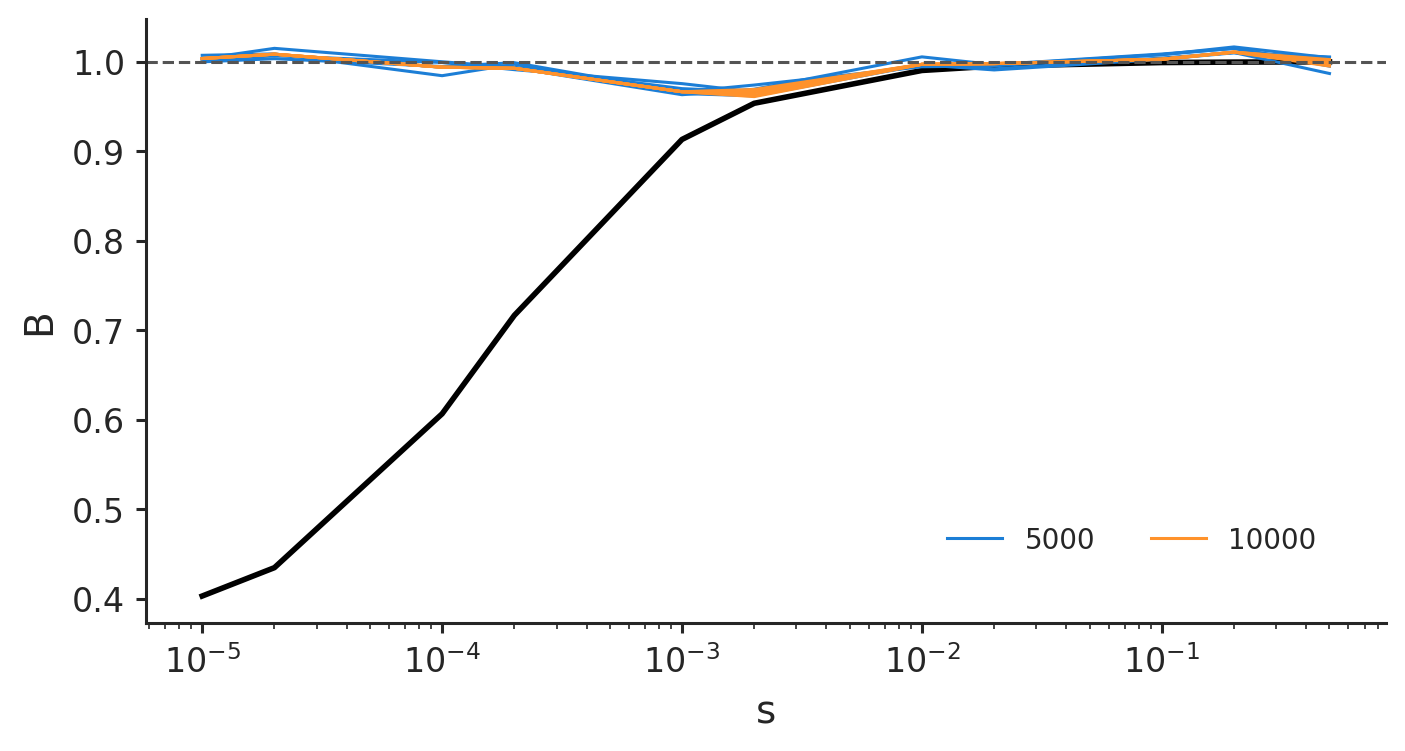

In [16]:
#ns = [50, 100, 500, 1000, 5000, 10_000]
ns = [1000, 2000, 5000, 10_000]


def plot_subsamples(d, ns, qualitative=False):
    cols = [v['color'] for v in list(mpl.rcParams['axes.prop_cycle'])]

    d_grp_sort = group_means(d).sort_values(['sh'])
    if qualitative:
        plt.plot([str(v) for v in d_grp_sort['sh']], d_grp_sort['theory'], c='k', linewidth=2)
    else:
        plt.plot([v for v in d_grp_sort['sh']], d_grp_sort['theory'], c='k', linewidth=2)
    #plt.ylim(0.9, 1.1)

    vars = defaultdict(list)
    labs = set()
    for i, n in enumerate(ns):
        means = []
        for rep in range(5):
            ds = group_means(subsample_reps(d, n))
            lab = n if n not in labs else None
            means.append(ds['y'].values)
            if qualitative:
                plt.plot([str(v) for v in ds['sh']], ds['y'], c=cols[i], label=lab)
            else:
                plt.plot([v for v in ds['sh']], ds['y'], c=cols[i], label=lab)
            labs.add(lab)

            #plt.scatter([str(v) for v in vds['sh']], vds['y'], c=cols[i])
        vars[n].append(np.array(means).var(axis=0))

    plt.axhline(1, linestyle='dashed', c='0.33')
    plt.legend(ncol=4)
    plt.ylabel('B')
    plt.xlabel('s')
    if not qualitative:
        plt.semilogx()

plot_subsamples(vd.loc[(vd.mu == 1e-8)], [5000, 10_000])

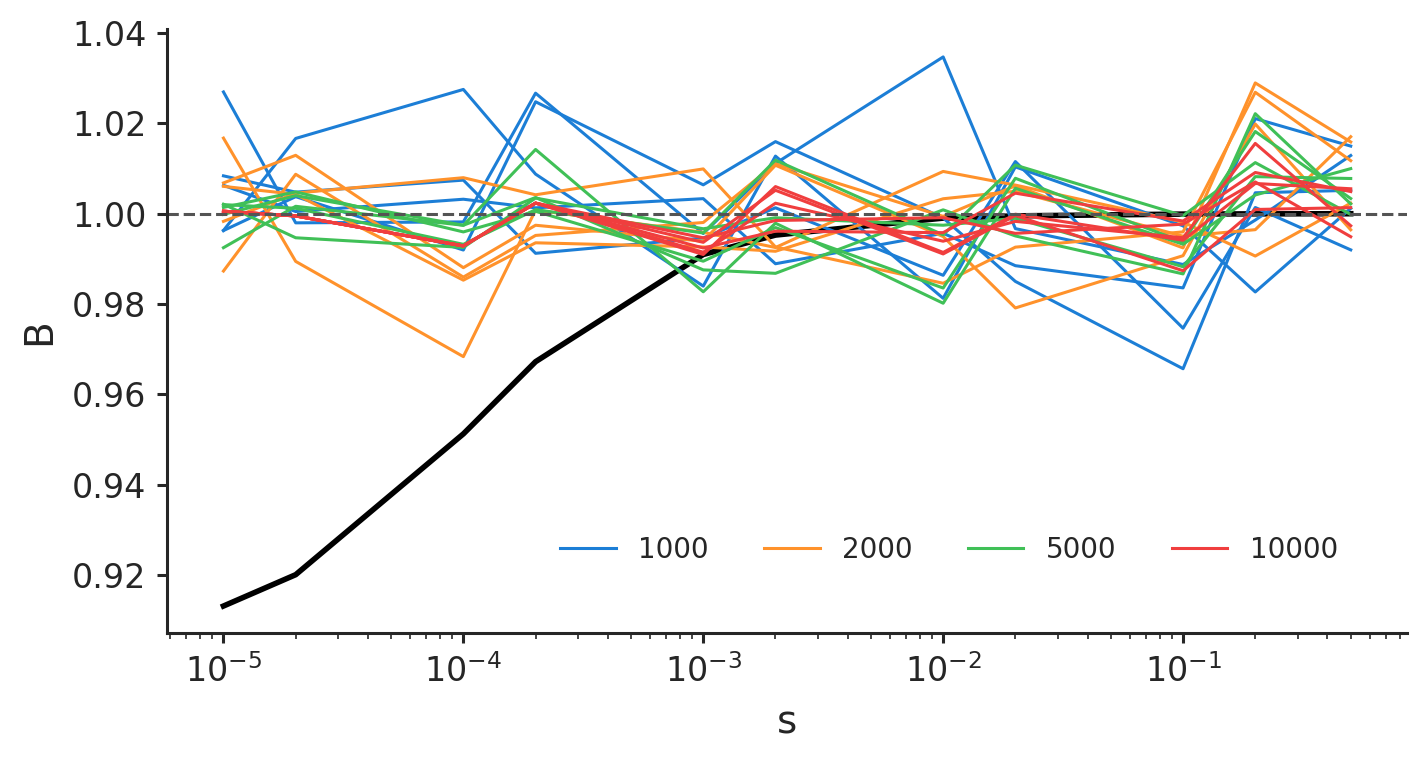

In [17]:
plot_subsamples(vd.loc[(vd.mu == 1e-9)], ns)

In [42]:
vd = load_validation('../data/slim_sims/validate_dim/validate_dim.npz')

vd_means = group_means(vd)

vd['muL'] = [str(signif(v, 2)) for v in vd['mu']*vd['L']]
vd = vd.sort_values(['muL'])

vd_means['muL'] = [str(signif(v, 2)) for v in vd_means['mu']*vd_means['L']]
vd_means = vd_means.sort_values(['muL'])

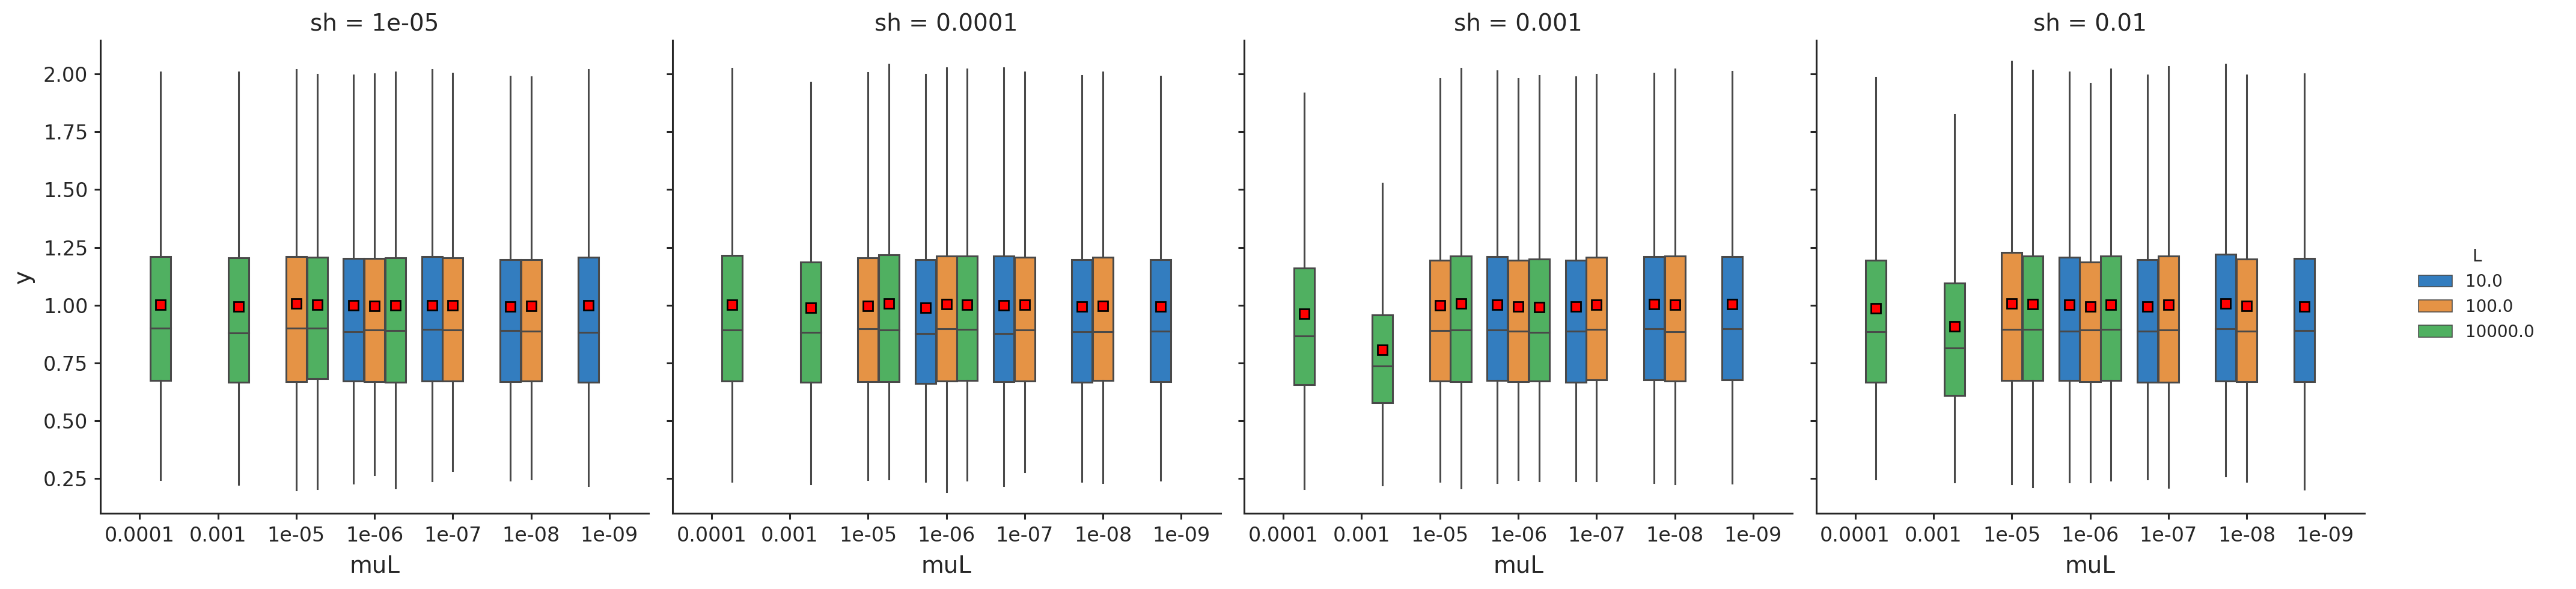

In [43]:
sns.catplot(x='muL', y='y', hue='L', data=vd, col='sh', kind='box', showmeans=True)

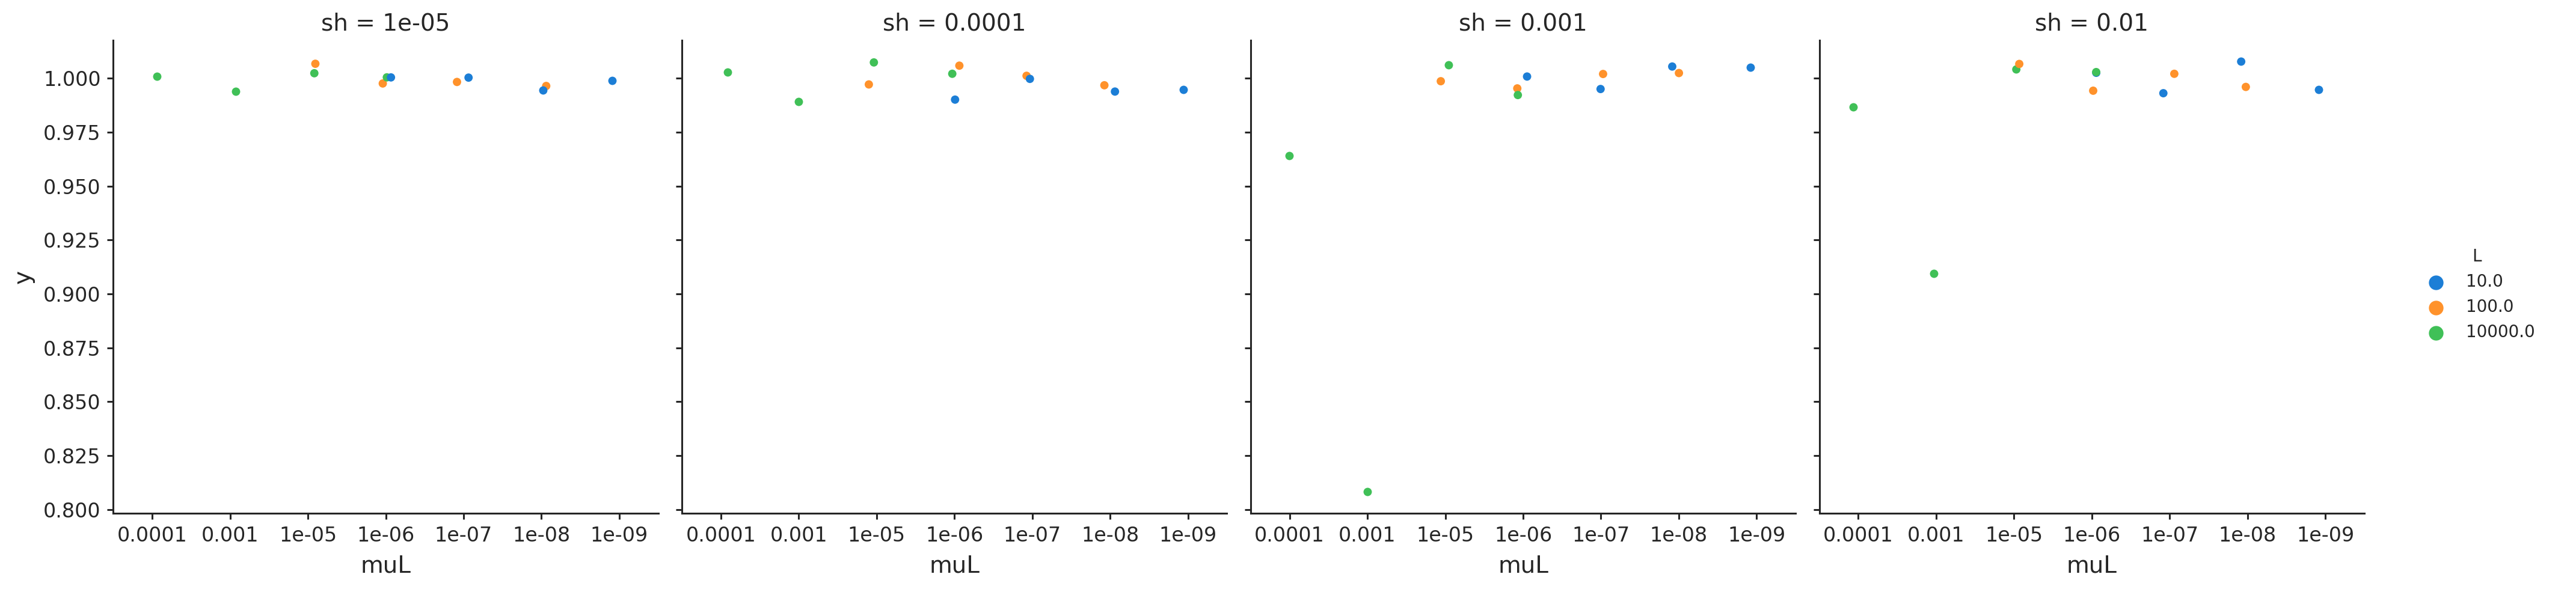

In [45]:
sns.catplot(x='muL', y='y', hue='L', data=vd_means, col='sh')

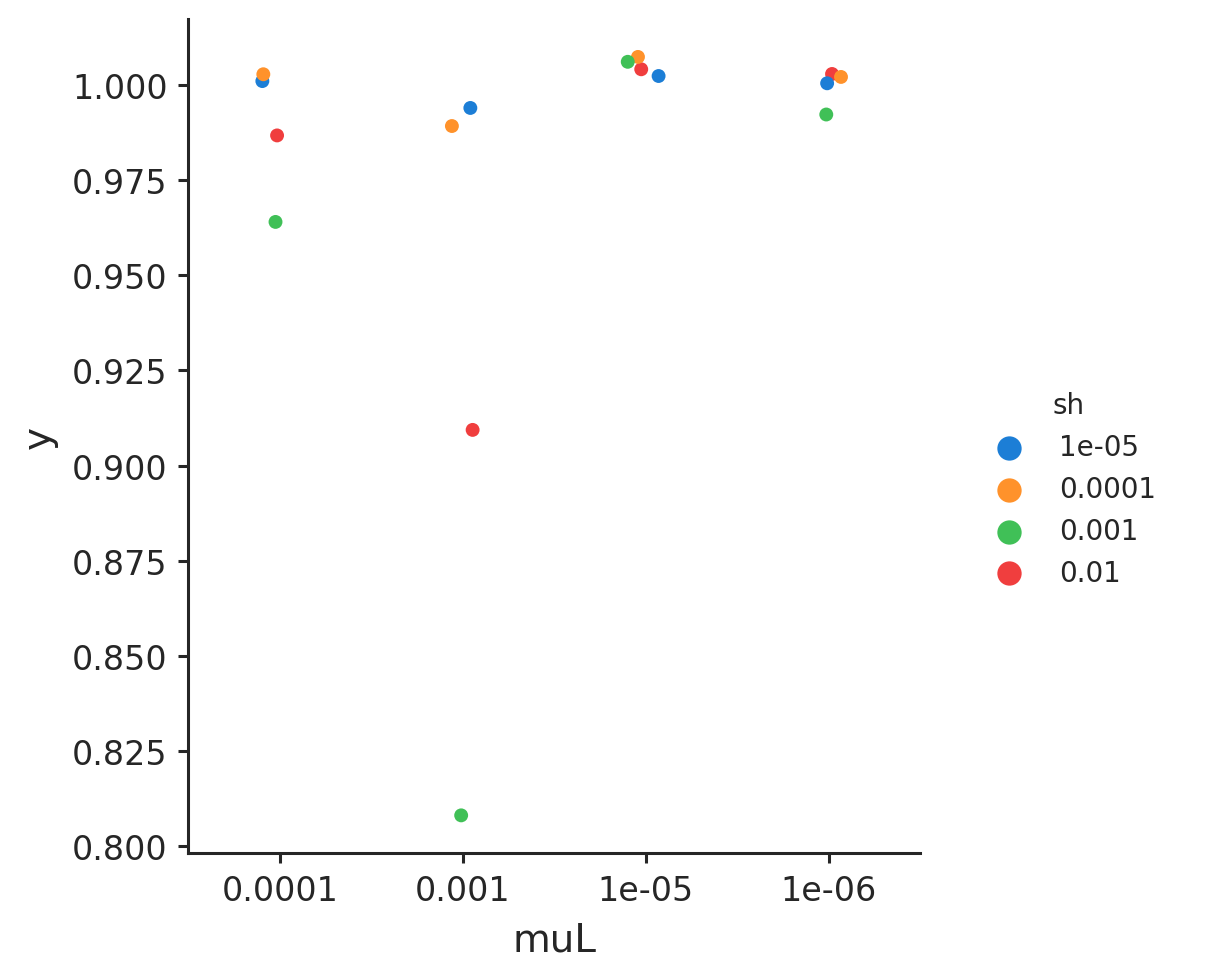

In [47]:
sns.catplot(x='muL', y='y', hue='sh', data=vd_means.loc[vd_means['L'] == 10_000])